# Overview

The task at hand is classification of wine quality

We will use 3 different approaches:

- A standard neural network (feed fordward nn)
- A bayesian neural network that will take into account epistemic (model) uncertainty on the predicted labels
- A probabilistic neural network that will take into account both aleatoric (data) and epistemic (model) uncertainty on the predicted labels

## Workflow

1. [Data Inspection](#inspection) 
    - Loading
    - Inspection
    - Preprocessing
2. [Modeling](#model-definition)
    - Standard Neural Network
    - Bayesian Neural Network
    - Probabilistic Neural Network
3. [Prediction](#prediction)

In [3]:
# Software install (as required)
#!pip install -r ../requirements.txt

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

2023-05-25 13:45:02.694442: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 13:45:04.662780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 13:45:04.663641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 13:45:08.997464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/codespace/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Inspection <a name="inspection"></a>

In [5]:
def load_data(dataset_name="wine_quality",buffer_size=4998,split="train",batch_size=256,train_size=3000):
    # Data Load
    ds , ds_info = tfds.load(
        name=dataset_name, 
        as_supervised=True, 
        split=split ,
        with_info=True
        )
        
    # Data prefetch (to keep GPU busy) and cache (to reload from mem , not disk)
    (ds.map(lambda x, y: (x, tf.cast(y, tf.float32)))
        .prefetch(buffer_size=buffer_size)
        .cache()
    )

    return ds, ds_info

def split_data(dataset,batch_size=256,train_size=3000):
    # Data Split
    # Train : we shuffle with a buffer the same size as the dataset.
    ds_train = (
        dataset
        .take(train_size)
        .shuffle(buffer_size=train_size)
        .batch(batch_size)
    )
    # Test : no shuffle
    ds_test = (
        dataset
        .skip(train_size)
        .batch(batch_size)
    )

    return ds_train,ds_test


In [6]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)

# load data
ds ,ds_info = load_data(
    dataset_name="wine_quality",
    buffer_size=dataset_size, # We prefetch with a buffer the same size as the dataset because th dataset is very small and fits into memory.
    ) 
    
# split data
ds_train,ds_test = split_data(
    dataset=ds,
    batch_size=batch_size,
    train_size=train_size)

In [8]:
# Basic Info
feature_names=list(ds_info.features['features'].keys())
print("Total examples: %d" %(len(ds_train)+len(ds_test)))
print("Train set size: %d" %len(ds_train)) 
print("Test set size : %d" %len(ds_test))   
print("Feature names : %s" %feature_names)

Total examples: 20
Train set size: 17
Test set size : 3
Feature names : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [9]:
# show a few examples from the train dataset
tfds.as_dataframe(ds_train.unbatch().take(10), ds_info)

2023-05-25 13:45:31.343678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-25 13:45:31.344487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 13:45:31.636503: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity,quality
0,9.300000190734863,0.039000000804662704,0.27000001072883606,0.9981499910354614,7.599999904632568,31.0,3.2699999809265137,10.600000381469727,0.30000001192092896,119.0,0.30000001192092896,6
1,10.899999618530273,0.039000000804662704,0.2800000011920929,0.9946900010108948,6.699999809265137,29.0,3.109999895095825,10.199999809265137,0.44999998807907104,115.0,0.18000000715255737,7
2,10.0,0.05400000140070915,0.2800000011920929,0.996999979019165,7.800000190734863,78.0,3.140000104904175,10.199999809265137,0.46000000834465027,186.0,0.20000000298023224,6
3,12.199999809265137,0.04399999976158142,0.7400000095367432,0.9909999966621399,7.099999904632568,42.0,3.309999942779541,2.700000047683716,0.4099999964237213,144.0,0.2199999988079071,6
4,11.399999618530273,0.02199999988079071,0.2800000011920929,0.9907000064849854,6.300000190734863,28.0,3.200000047683716,1.7999999523162842,0.6399999856948853,158.0,0.1899999976158142,6
5,9.899999618530273,0.04399999976158142,0.27000001072883606,0.9945399761199951,6.800000190734863,45.0,3.200000047683716,8.600000381469727,0.3700000047683716,104.0,0.10999999940395355,6
6,9.199999809265137,0.052000001072883606,0.3400000035762787,0.9962700009346008,7.400000095367432,44.0,3.109999895095825,8.300000190734863,0.5199999809265137,168.0,0.3799999952316284,5
7,10.0,0.04399999976158142,0.27000001072883606,0.9966999888420105,6.5,69.0,3.1700000762939453,12.899999618530273,0.4300000071525574,215.0,0.25999999046325684,6
8,9.0,0.050999999046325684,0.2800000011920929,0.9979199767112732,7.0,29.0,2.9600000381469727,14.699999809265137,0.38999998569488525,149.0,0.15000000596046448,7
9,9.5,0.04800000041723251,0.3499999940395355,0.9958999752998352,6.800000190734863,76.0,3.240000009536743,7.800000190734863,0.4300000071525574,197.0,0.27000001072883606,6


In [10]:
# Class balance check : is the dataset imbalanced?
#fig, ax = plt.subplots(1, 1, figsize=(10,6))
#labels, counts = np.unique(np.fromiter(ds.unbatch().map(lambda x, y: y), np.int32),  return_counts=True)
#ax.set_xlabel('Counts')
#ax.set_title("Counts by type");
#sns.barplot(x=counts, y=[class_names[l] for l in labels], label="Total")
#ax.grid(True,ls='--')
#sns.despine(left=True, bottom=True)

In [11]:
# IF needed
def prepare_for_training(ds, cache=True, batch_size=1, shuffle_buffer_size=1000):
  ds = ds.map(lambda x, y: (x, tf.cast(y, tf.float32)))
  ds = ds.prefetch(buffer_size=4898)
  ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model is training.
  return ds

In [12]:
# Function to create model inputs
def create_model_inputs(feature_names=[]):
    inputs = {}
    for name in feature_names:
        print('creating model input layer for : %s' %name)
        inputs[name] = layers.Input(
            name=name.replace(" ","_"), shape=(1,), dtype=tf.float32
        )
    return inputs

# Function to define a prior model in the context of Bayesian inference
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Function to define a posterior model in the context of Bayesian inference
# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


# Create Standard Neural Network
def base_neural_network(hidden_units=None,inputs=None,feature_names=[]):
    if inputs is None:
        inputs = create_model_inputs(feature_names=feature_names)
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs,name='StandardNeuralNet')
    return model

# Create Bayesian Neural Network : to capture epistemic (model) uncertainty due to limited training data
def bayesian_neural_network(train_size=1000,hidden_units=None,inputs=None,feature_names=[],activation='sigmoid'):
    if inputs is None:
        inputs = create_model_inputs(feature_names=feature_names)
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=activation,
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs,name='BayesNeuralNet')
    return model


# Function to train and evaluate a model (experiment run)
def run_experiment(model, loss, train_dataset, test_dataset, num_epochs, learning_rate,save=True,model_filename=""):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Model training started ...")
    history = model.fit(
        train_dataset, 
        epochs=num_epochs, 
        validation_data=test_dataset)
    
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

    # save model as required
    if save:
        print('saving model : %s' %model_filename)
        model.save(model_filename)
    
    return history

# Function to plot the training history
def plot_training(history,namealpha=1.,learning_rate=0.01,figsize=(8,6)):
    # PLot training history for loss
    title= history.model.name + ' learning rate :' + str(learning_rate)
    f,ax=plt.subplots(1,1,figsize=figsize)
    ax.plot(history.history['loss'],label='Train Loss',alpha=0.5)
    ax.plot(history.history['val_loss'],label='Val Loss',alpha=0.5)
    plt.title(title)
    plt.ylabel('loss',fontsize=10)
    plt.xlabel('epoch',fontsize=10)
    plt.legend(loc='upper right',fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

In [13]:
arch_type = 'nn'
model_filename = "wine_quality_classification_"+arch_type
model_path = os.path.join("../models", model_filename + ".h5")
if not os.path.exists("../models"):
    os.makedirs(model_path)

### Train Base Neural Network <a name="model training"></a>

In [14]:
hidden_units = [8, 8]
learning_rate = 0.001
num_epochs = 100
nn_model = base_neural_network(hidden_units=hidden_units,feature_names=feature_names)
history = run_experiment(
    model=nn_model, 
    loss=keras.losses.MeanSquaredError(), 
    train_dataset=ds_train, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    model_filename=model_filename)


creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/100


2023-05-25 13:45:39.529049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-25 13:45:39.529600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-25 13:45:40.611473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

 1/17 [>.............................] - ETA: 24s - loss: 23.4346 - root_mean_squared_error: 4.8409

2023-05-25 13:45:41.127547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-25 13:45:41.128111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


17/17 [==============================] - 2s 26ms/step - loss: 22.0059 - root_mean_squared_error: 4.6910 - val_loss: 21.0185 - val_root_mean_squared_error: 4.5846
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 20.4377 - root_mean_squared_error: 4.5208 - val_loss: 19.9638 - val_root_mean_squared_error: 4.4681
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 19.0894 - root_mean_squared_error: 4.3691 - val_loss: 18.8353 - val_root_mean_squared_error: 4.3400
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 17.7823 - root_mean_squared_error: 4.2169 - val_loss: 17.6496 - val_root_mean_squared_error: 4.2011
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 16.5026 - root_mean_squared_error: 4.0623 - val_loss: 16.4257 - val_root_mean_squared_error: 4.0529
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 15.2523 - root_mean_squared_error: 3.9054 - val_loss: 15.1834 - val_root_

INFO:tensorflow:Assets written to: wine_quality_classification_nn/assets


INFO:tensorflow:Assets written to: wine_quality_classification_nn/assets


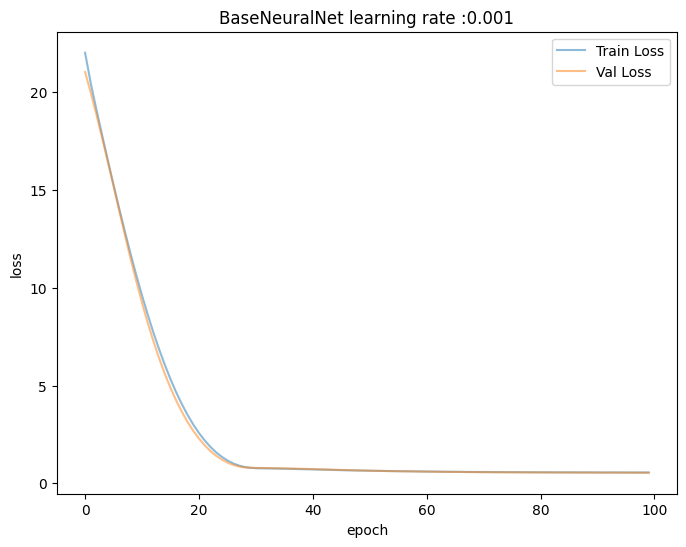

In [15]:
plot_training(history=history,learning_rate=learning_rate)

We take a sample from the test set use the model to obtain predictions for them. Note that since the baseline model is deterministic, we get a single a point estimate prediction for each test example, with no information about the uncertainty of the model nor the prediction.

### Make some predictions

In [17]:

sample = 10
examples, targets = list(ds_test.unbatch().shuffle(batch_size * 10).batch(sample))[
    0
]

predicted = nn_model(examples).numpy()
for idx in range(sample):
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")

Predicted: 5.5 - Actual: 5
Predicted: 5.7 - Actual: 4
Predicted: 5.5 - Actual: 6
Predicted: 6.2 - Actual: 6
Predicted: 4.5 - Actual: 5
Predicted: 6.6 - Actual: 8
Predicted: 5.4 - Actual: 5
Predicted: 5.6 - Actual: 6
Predicted: 6.3 - Actual: 6
Predicted: 5.7 - Actual: 5


2023-05-25 13:46:24.978107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-25 13:46:24.978806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


### Train Bayesian Neural Network on small sample

In [18]:
arch_type = 'Bayes_nn'
model_filename = "wine_quality_classification_"+arch_type
model_path = os.path.join("../models", model_filename + ".h5")
if not os.path.exists("../models"):
    os.makedirs(model_path)

In [19]:
num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = ds_train.unbatch().take(train_sample_size).batch(batch_size)

# build
bayes_nn_model_small = bayesian_neural_network(
    hidden_units=hidden_units,
    feature_names=feature_names,
    train_size=train_sample_size)
# train
history = run_experiment(
    model=bayes_nn_model_small, 
    loss=keras.losses.MeanSquaredError(), 
    train_dataset=small_train_dataset, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    model_filename=model_filename)



creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/500


2023-05-25 13:46:35.061072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-25 13:46:35.061919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 3s 239ms/step - loss: 46.3404 - root_mean_squared_error: 6.8065 - val_loss: 47.1188 - val_root_mean_squared_error: 6.8633
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 46.3891 - root_mean_squared_error: 6.8097 - val_loss: 44.1369 - val_root_mean_squared_error: 6.6423
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 48.2704 - root_mean_squared_error: 6.9467 - val_loss: 42.2243 - val_root_mean_squared_error: 6.4968
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 45.3759 - root_mean_squared_error: 6.7350 - val_loss: 43.2363 - val_root_mean_squared_error: 6.5742
Epoch 5/500
5/5 [==============================] - 0s 20ms/step - loss: 41.2944 - root_mean_squared_error: 6.4251 - val_loss: 44.6625 - val_root_mean_squared_error: 6.6821
Epoch 6/500
5/5 [==============================] - 0s 12ms/step - loss: 45.9064 - root_mean_squared_error: 6.7743 - val_loss: 42.2711 - val_root_mean_s

INFO:tensorflow:Assets written to: wine_quality_classification_Bayes_nn/assets


INFO:tensorflow:Assets written to: wine_quality_classification_Bayes_nn/assets


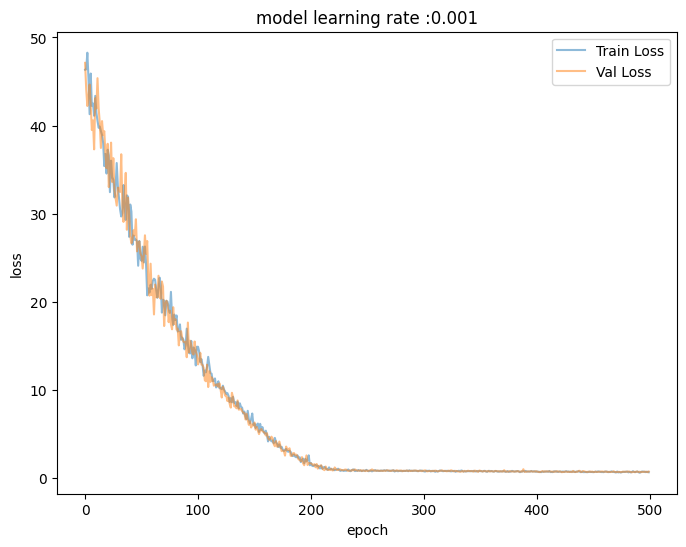

In [20]:
plot_training(history=history,learning_rate=learning_rate)

In [21]:
from statistics import NormalDist

def compute_predictions(model, input=None, iterations=100 , n_samples=10):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(input).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_std = np.std(predicted, axis=1).tolist()
    #prediction_min = np.min(predicted, axis=1).tolist()
    #prediction_max = np.max(predicted, axis=1).tolist()
    #prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(n_samples):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"Predictions  std: {round(prediction_std[idx], 2)}, "
            f"Actual: {targets[idx]}"
        )

    return predicted

def display_predictions(predictions=[], target_values=[], n_samples=10,n_bins=10,figsize=(15,6)):
    f,axs=plt.subplots(1,n_samples,figsize=figsize)
    for i in range(n_samples):
        data=list(predictions[i])
        # normal distribution from the data
        norm = NormalDist.from_samples(data)
        mu = norm.mean
        sigma = norm.stdev
        # plot the predictions
        n, bins, patches = axs[i].hist(data, n_bins, density=True, alpha=0.75)
        # add the fitted normal distribution line
        x = np.linspace(min(data),max(data),50)
        l = plt.plot(x, norm.pdf(x), 'g--', linewidth=2)
        axs[i].set_title(r'$Predictions \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
        # add the true target value
        axs[i].axvline(x=target_values[i],color='red',lw=2)

Predictions mean: 5.6, Predictions  std: 0.25, Actual: 5
Predictions mean: 5.96, Predictions  std: 0.16, Actual: 4
Predictions mean: 5.65, Predictions  std: 0.25, Actual: 6
Predictions mean: 6.19, Predictions  std: 0.11, Actual: 6
Predictions mean: 5.13, Predictions  std: 0.36, Actual: 5
Predictions mean: 6.26, Predictions  std: 0.11, Actual: 8
Predictions mean: 5.22, Predictions  std: 0.31, Actual: 5
Predictions mean: 5.62, Predictions  std: 0.23, Actual: 6
Predictions mean: 6.17, Predictions  std: 0.11, Actual: 6
Predictions mean: 5.8, Predictions  std: 0.21, Actual: 5


TypeError: NormalDist.pdf() takes 2 positional arguments but 4 were given

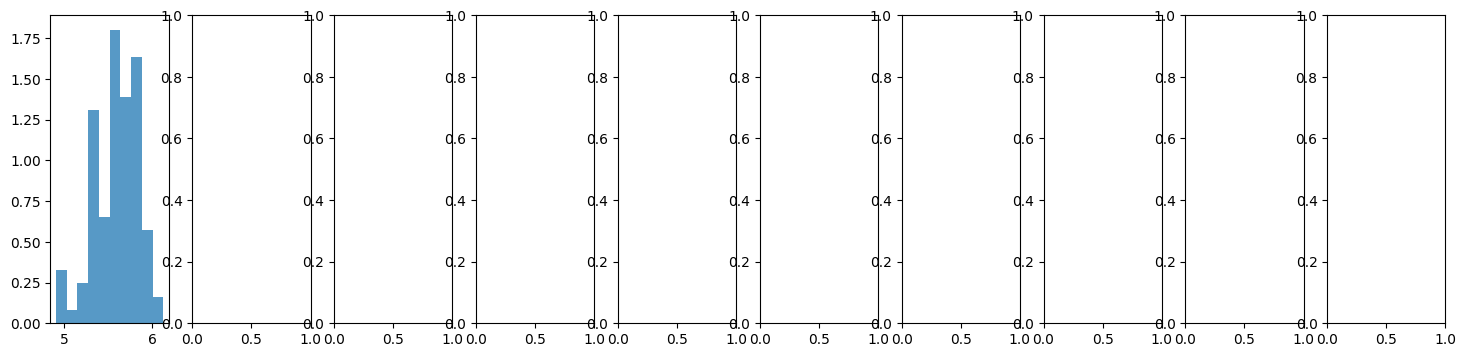

In [22]:
predictions=compute_predictions(
    model=bayes_nn_model_small,
    input=examples,
    )

display_predictions(
    predictions=predictions,
    target_values=targets,
    figsize=(18,4))

In [80]:
print(predictions[0])

[5.8834815 5.687369  5.8666735 5.7293415 6.0238566 5.939475  5.6986103
 5.3060117 6.0217667 6.0299506 6.0386915 5.846163  5.992629  5.6183267
 5.9939513 6.1320467 6.124373  5.8007545 6.047509  5.6588635 5.8658895
 5.8370724 6.087043  5.9382277 6.229044  6.1058793 5.8369427 5.7033806
 6.0486774 5.8437996 5.7862062 5.782301  5.898985  5.7549896 5.772032
 5.8812375 6.1269875 5.9422007 6.0459595 6.0226088 5.5432196 6.0476956
 5.8739214 5.9618382 5.8478093 5.860327  6.0561666 6.108446  5.7883105
 5.900117  5.666078  5.7933393 5.821084  6.040549  6.0364313 5.648493
 5.9070854 6.050929  6.026209  5.8574286 6.0043693 6.0715113 5.818759
 5.8431044 6.15386   6.0542507 5.9215956 6.122848  6.150097  5.684157
 5.7794895 6.132325  6.1865177 6.0918036 6.0483475 5.53798   5.9065948
 6.0086927 6.1754875 6.076694  5.7914934 5.75861   6.161569  5.8621445
 6.107136  6.043453  5.9173827 6.057573  5.842243  5.9897933 5.8412704
 5.852641  6.2168803 6.010903  5.8103347 6.0813746 6.0341377 5.768103
 5.7992682 